In [1]:
# Import Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
from itertools import cycle
from datetime import datetime, timedelta
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display
from scipy import stats

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence, select_months
from eofs import *
from ar_funcs import get_ar_days, duration_stats
from kmeans import *
import nclcmaps as ncl

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# choose parameters
reanalysis = 'era5'
ssn = 'djfmam'
ceofid = 'IVT'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

# import configuration file for season dictionary choice
yaml_doc = '../data/plt_config.yml'
config1 = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)

ar_dict = config1[ssn]
start_date = ar_dict['start_date']
end_date = ar_dict['end_date']
print(start_date, end_date)

1979-12-01 9:00 2019-05-31 9:00


In [4]:
# load AR CAT
filepath = out_path + 'AR-types-loadings.csv'
ar_cat = pd.read_csv(filepath)
ar_cat = ar_cat.set_index(pd.to_datetime(ar_cat['date']))
ar_cat.index = ar_cat.index.strftime("%Y-%m-%d")
ar_cat = ar_cat.drop(columns=['date', 'EOF1', 'EOF2'])
ar_cat = ar_cat.reset_index()
ar_cat

,date,AR_CAT
0,1979-12-01,2
1,1979-12-02,1
2,1979-12-08,2
3,1979-12-09,1
4,1979-12-16,1
...,...,...
3152,2019-05-19,1
3153,2019-05-21,1
3154,2019-05-24,3
3155,2019-05-25,3


In [5]:
%%time
# if using single bound box with elevation mask
bound_box = [20, 40, 65, 97]
trackIDs, df = get_ar_days(reanalysis, start_date, end_date, subregions=False, bbox=bound_box, elev_thres=1000.)
df

# # if using 3 subregions and threshold
# trackIDs, df = get_ar_days(reanalysis, start_date, end_date, subregions=True, bbox=None, thresh=0.05)
# df



CPU times: user 26.1 s, sys: 2.71 s, total: 28.8 s
Wall time: 27.9 s


,ar
time,
1979-12-01 09:00:00,1.0
1979-12-02 09:00:00,1.0
1979-12-03 09:00:00,0.0
1979-12-04 09:00:00,0.0
1979-12-05 09:00:00,0.0
...,...
2019-05-27 09:00:00,0.0
2019-05-28 09:00:00,0.0
2019-05-29 09:00:00,1.0


In [6]:
trackIDs

time
1979-12-01 12:00:00    [2864.0, 2861.0]
1979-12-01 18:00:00    [2864.0, 2861.0]
1979-12-02 00:00:00            [2861.0]
1979-12-02 06:00:00            [2861.0]
1979-12-02 12:00:00            [2861.0]
                             ...       
2019-05-21 12:00:00          [128712.0]
2019-05-24 00:00:00          [128755.0]
2019-05-25 00:00:00          [128763.0]
2019-05-25 12:00:00          [128756.0]
2019-05-29 06:00:00          [128807.0]
Name: kidmap, Length: 15051, dtype: object

In [7]:
track_ct = trackIDs.to_frame()
track_ct = select_months(track_ct, 12, 5)
ar_ct = []
for i in range(len(track_ct)):
    ar_ct.append(len(track_ct.kidmap[i]))

track_ct['ar_ct'] = ar_ct
track_ct
track_ct.groupby('ar_ct').count()

,kidmap
ar_ct,
1,7197
2,307
3,3


In [8]:
# how many ARs in HMA between start date and end date?
print('Number of ARs between 1979 and 2019: ', df.ar.sum())
# how many ARs on average per year?
print('Average number of ARs per year: ', df.ar.sum()/39.)

Number of ARs between 1979 and 2019:  6634.0
Average number of ARs per year:  170.10256410256412


### Annual Climatology

In [9]:
clim_ct = df.ar.groupby(df.index.month).sum()
clim_ct

time
1     457.0
2     532.0
3     705.0
4     554.0
5     499.0
6     685.0
7     810.0
8     628.0
9     536.0
10    463.0
11    355.0
12    410.0
Name: ar, dtype: float64

/home/nash/DATA/repositories/AR_types/figs/ar_barplot.png


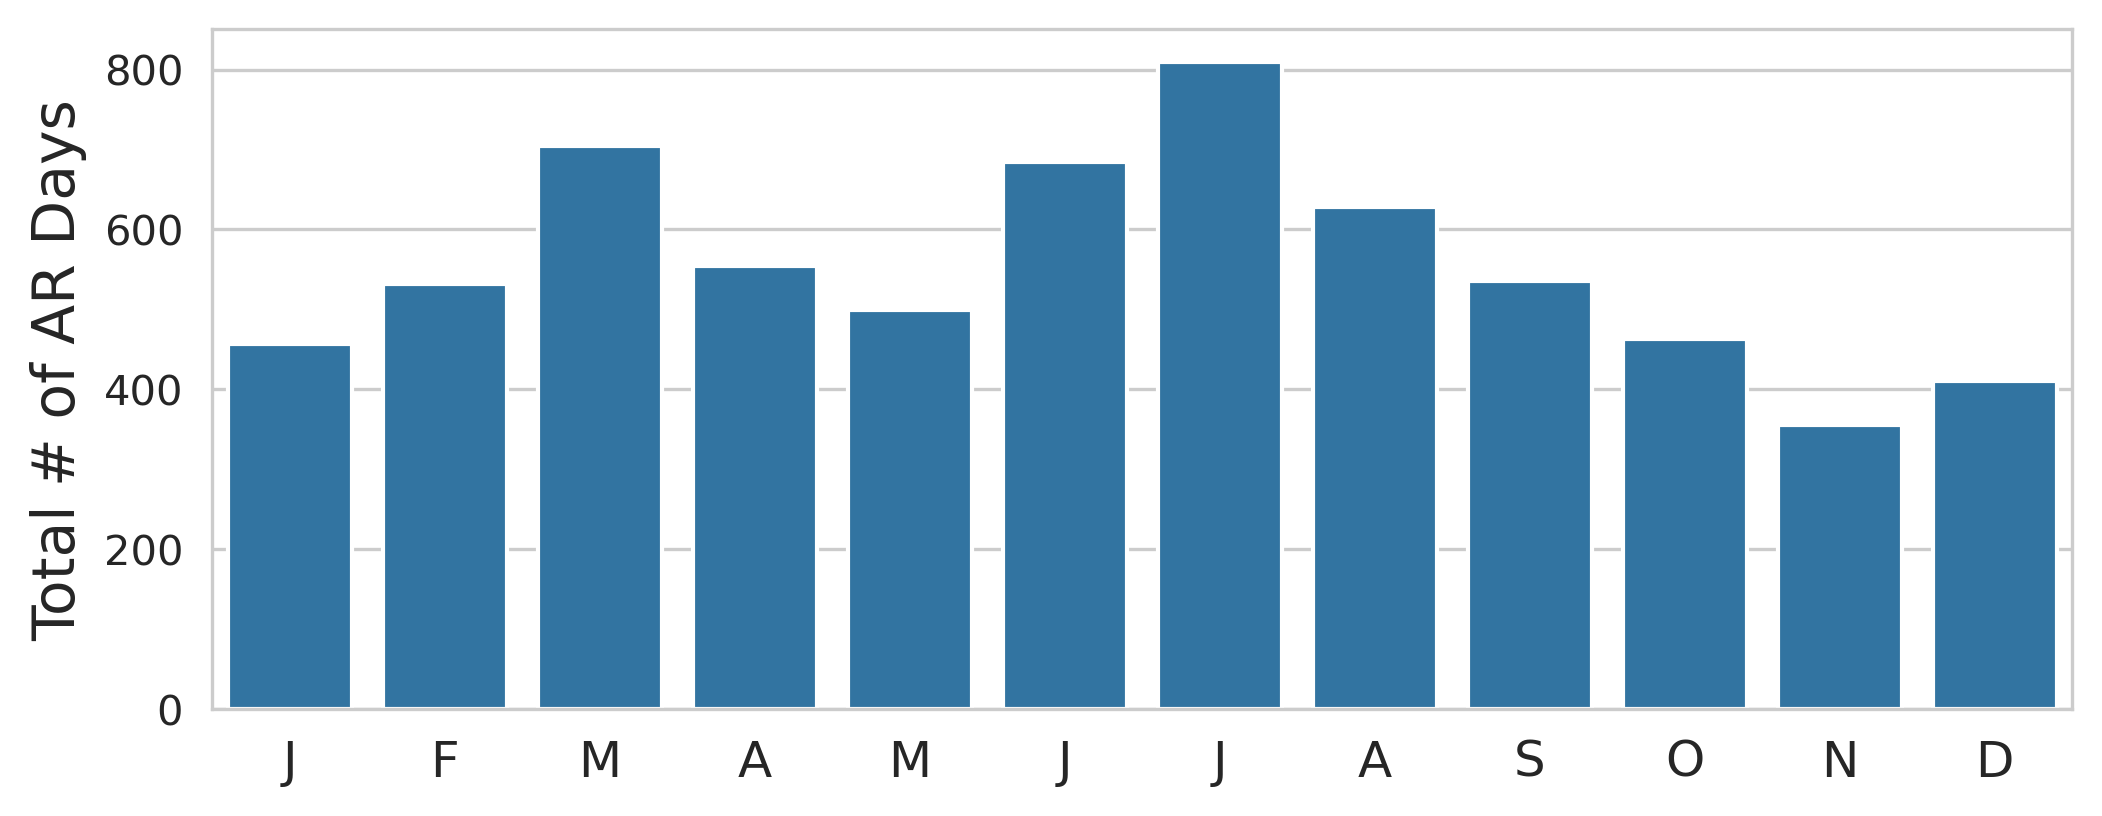

<Figure size 2400x900 with 0 Axes>

In [10]:
fname = path_to_figs + 'ar_barplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.0,3.0))
fig.dpi = 300
nplots=1

# Set custom color palette
colors = ["#003660"]
sns.set_palette(sns.color_palette(colors))
columns=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
          
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.despine()

for i in np.arange(nplots):
    ax = fig.add_subplot(1, 1, i+1)
    sns.barplot(x=np.arange(1, 13, 1), y=clim_ct, color='tab:blue')
#     ax.set_title('AR Frequency (1980-2015)', fontsize=12)
    ax.set_ylabel('Total # of AR Days', fontsize=14)
    ax.set_xticklabels(columns, fontsize=12)
#     ax.legend(loc='upper left')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

### Select ARs by Season

In [11]:
# select only rows with AR covering > 30% of area
idx = (df.ar > 0)
df_tmp = df.loc[idx]
# print(len(df_tmp))
djf_df = select_months(df_tmp, 12, 2)
mam_df = select_months(df_tmp, 3, 5)
djfmam_df = select_months(df_tmp, 12, 5)

In [12]:
# df = trackIDs.to_frame()
# df = df.groupby(pd.Grouper(freq='1D')).kidmap.unique()
# # test = df.groupby(pd.Grouper(freq='1D')).apply(lambda x: x.kidmap.unique())
# df

# df['LEN'] = df['kidmap'].apply(lambda df: [df['kidmap'] for eachdict in ourlist].count(datetimeobject))
# test = len(df['kidmap'])
# test

# # trackIDs = trackIDs.set_index('time')
# test = trackIDs.groupby(pd.Grouper(freq='1D')).min()
# test = select_months(test, 12, 5)
# idx = (test.kidmap > 0)
# test = test.loc[idx]
# test

# outfile = path_to_out + 'DJFMAM_ARS_TRACKID_daily.csv'
# test.to_csv(outfile)
# test

In [13]:
id_df = select_months(trackIDs, 12, 5)
id_df = id_df.to_frame()
id_df = id_df.reset_index()
id_df = id_df.rename(columns={'time': 'date'})
id_df = id_df.set_index(pd.to_datetime(id_df['date']))
id_df.index = id_df.index.strftime("%Y-%m-%d")
id_df = id_df.rename(columns={'date': 'time'})
id_df = id_df.reset_index()
id_df = id_df.explode('kidmap')
id_df

,date,time,kidmap
0,1979-12-01,1979-12-01 12:00:00,2864.0
0,1979-12-01,1979-12-01 12:00:00,2861.0
1,1979-12-01,1979-12-01 18:00:00,2864.0
1,1979-12-01,1979-12-01 18:00:00,2861.0
2,1979-12-02,1979-12-02 00:00:00,2861.0
...,...,...,...
7502,2019-05-21,2019-05-21 12:00:00,128712.0
7503,2019-05-24,2019-05-24 00:00:00,128755.0
7504,2019-05-25,2019-05-25 00:00:00,128763.0
7505,2019-05-25,2019-05-25 12:00:00,128756.0


In [14]:
# merge id_df with ar_cat
test = pd.merge(id_df, ar_cat, how='outer', on='date')
# get list of unique track_ids for HMA ARs
trackID_ct = test.kidmap.nunique()
track_ids = test.kidmap.unique()

outfile = path_to_out + 'DJFMAM_ARS_TRACKID_explode.csv'
test.to_csv(outfile)
test

,date,time,kidmap,AR_CAT
0,1979-12-01,1979-12-01 12:00:00,2864.0,2
1,1979-12-01,1979-12-01 12:00:00,2861.0,2
2,1979-12-01,1979-12-01 18:00:00,2864.0,2
3,1979-12-01,1979-12-01 18:00:00,2861.0,2
4,1979-12-02,1979-12-02 00:00:00,2861.0,1
...,...,...,...,...
7815,2019-05-21,2019-05-21 12:00:00,128712.0,1
7816,2019-05-24,2019-05-24 00:00:00,128755.0,3
7817,2019-05-25,2019-05-25 00:00:00,128763.0,3
7818,2019-05-25,2019-05-25 12:00:00,128756.0,3


In [17]:
# count the number of AR objects per day
tmp = test.groupby('date').kidmap.unique()
track_ct = tmp.to_frame()
ar_ct = []
for i in range(len(track_ct)):
    ar_ct.append(len(track_ct.kidmap[i]))

track_ct['ar_ct'] = ar_ct
track_ct
track_ct.groupby('ar_ct').count()

,kidmap
ar_ct,
1,2629
2,475
3,50
4,3


In [22]:
ar_cat.AR_CAT.values

array([2, 1, 2, ..., 3, 3, 1])

In [23]:
track_ct['ar_cat'] = ar_cat.AR_CAT.values
track_ct

,kidmap,ar_ct,ar_cat
date,,,
1979-12-01,"[2864.0, 2861.0]",2,2
1979-12-02,[2861.0],1,1
1979-12-08,[2871.0],1,2
1979-12-09,[2871.0],1,1
1979-12-16,[2975.0],1,1
...,...,...,...
2019-05-19,[128712.0],1,1
2019-05-21,[128712.0],1,1
2019-05-24,[128755.0],1,3


In [25]:
track_ct.groupby(['ar_cat', 'ar_ct']).count()

kidmap
ar_cat ar_ct        
1      1         727
       2         118
       3          12
2      1         727
       2         143
       3          14
       4           2
3      1        1175
       2         214
       3          24
       4           1

In [13]:
# create df with trackID, ar_cat, start date, end date, and duration of AR
ar = []
data = []
for i in [1, 2, 3]:
    idx = (test.AR_CAT == i)
    ar = test.loc[idx]

    for j, ids in enumerate(track_ids):
        idx = (ar.kidmap == ids)
        tmp = ar.loc[idx]
        start = pd.to_datetime(tmp.time.min())
        stop = pd.to_datetime(tmp.time.max()) + timedelta(hours=6)
        tmp = (stop - start)
        duration = tmp.total_seconds()/(3600) # convert to number of hours

        data.append([ids, i, start, stop, duration])
    
duration_df = pd.DataFrame(data, columns=['trackID', 'ar_cat', 'start_date', 'end_date', 'duration'])
duration_df

,trackID,ar_cat,start_date,end_date,duration
0,2864.0,1,NaT,NaT,NaN
1,2861.0,1,1979-12-02 00:00:00,1979-12-02 18:00:00,18.0
2,2871.0,1,1979-12-09 06:00:00,1979-12-09 18:00:00,12.0
3,2975.0,1,1979-12-16 12:00:00,1979-12-17 00:00:00,12.0
4,2988.0,1,1979-12-21 00:00:00,1979-12-22 12:00:00,36.0
...,...,...,...,...,...
6829,128712.0,3,NaT,NaT,NaN
6830,128755.0,3,2019-05-24 00:00:00,2019-05-24 06:00:00,6.0
6831,128763.0,3,2019-05-25 00:00:00,2019-05-25 06:00:00,6.0
6832,128756.0,3,2019-05-25 12:00:00,2019-05-25 18:00:00,6.0


In [14]:
duration_df = duration_df.dropna()
duration_df

,trackID,ar_cat,start_date,end_date,duration
1,2861.0,1,1979-12-02 00:00:00,1979-12-02 18:00:00,18.0
2,2871.0,1,1979-12-09 06:00:00,1979-12-09 18:00:00,12.0
3,2975.0,1,1979-12-16 12:00:00,1979-12-17 00:00:00,12.0
4,2988.0,1,1979-12-21 00:00:00,1979-12-22 12:00:00,36.0
5,3026.0,1,1979-12-24 06:00:00,1979-12-24 12:00:00,6.0
...,...,...,...,...,...
6824,128613.0,3,2019-05-06 06:00:00,2019-05-06 12:00:00,6.0
6825,128655.0,3,2019-05-12 06:00:00,2019-05-12 12:00:00,6.0
6830,128755.0,3,2019-05-24 00:00:00,2019-05-24 06:00:00,6.0
6831,128763.0,3,2019-05-25 00:00:00,2019-05-25 06:00:00,6.0


In [15]:
bins = np.array([[0, 24], [24, 2*24], [2*24, 3*24], [3*24, 4*24], [4*24, 5*24], [5*24, 6*24], [6*24, 7*24]])
sizes = []
freqs = []

for i in [1, 2, 3]:
    idx = (duration_df.ar_cat == i)
    tmp = duration_df.loc[idx]

    size, freq = duration_stats(tmp.duration, bins)
    sizes.append(size)
    freqs.append(freq)

size_all, freq_all = duration_stats(duration_df.duration, bins)    

In [16]:
print(sum(freq))

99.92050874403816


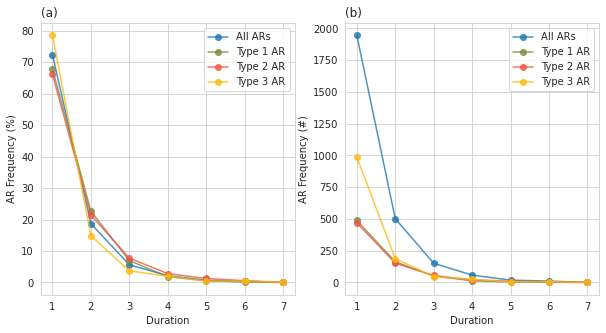

In [17]:
colors = np.array(([122/256, 141/256, 57/256, 1], # green
                   [239/256, 86/256, 69/256, 1],  # coral
                   [254/256, 188/256, 17/256, 1]))  # gold

# Create figure
fig = plt.figure(figsize=(10,5))
fname = fig_path + 'ar_duration_category'
fmt = 'png'
nrows = 1
ncols = 2
nplots=nrows*ncols

sns.set_style("whitegrid")

ax = fig.add_subplot(nrows, ncols, 1)

# plot data
xvals = np.arange(1, 8, 1)
ax.plot(xvals, freq_all,'o-', color='tab:blue', alpha=0.8, label='All ARs')
ax.plot(xvals, freqs[0],'o-', color=colors[0], alpha=0.8, label='Type 1 AR')
ax.plot(xvals, freqs[1],'o-', color=colors[1], alpha=0.8, label='Type 2 AR')
ax.plot(xvals, freqs[2],'o-', color=colors[2], alpha=0.8, label='Type 3 AR')

# x-axis
ax.set_xlabel('Duration')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('AR Frequency (%)')
# ax.set_yticks(np.arange(0, 21, 3))
ax.set_title('(a)', loc='left')

ax.legend()

ax2 = fig.add_subplot(nrows, ncols, 2)

# plot data
xvals = np.arange(1, 8, 1)
ax2.plot(xvals, size_all,'o-', color='tab:blue', alpha=0.8, label='All ARs')
ax2.plot(xvals, sizes[0],'o-', color=colors[0], alpha=0.8, label='Type 1 AR')
ax2.plot(xvals, sizes[1],'o-', color=colors[1], alpha=0.8, label='Type 2 AR')
ax2.plot(xvals, sizes[2],'o-', color=colors[2], alpha=0.8, label='Type 3 AR')

# x-axis
ax2.set_xlabel('Duration')
ax2.set_xticks(xvals)

# y-axis
ax2.set_ylabel('AR Frequency (#)')
# ax.set_yticks(np.arange(0, 21, 3))
ax2.set_title('(b)', loc='left')

ax2.legend()

In [19]:
# ## write djfmam dates and trackID to csv in out folder for subregion method
# # Export dataframe as csv
# outfile = path_to_out + 'DJFMAM_ARS_TRACKID.csv'
# tmp = djfmam_df.drop(['R01', 'R02', 'R03', 'R04', 'ar', 'location'], axis=1)
# tmp.to_csv(outfile)
# print(outfile)
# tmp.head()

In [20]:
# how many ARs in HMA between start date and end date?
print('Number of ARs between 1979 and 2019: ', df.ar.sum())
# how many ARs on average per year?
print('Average number of ARs per year: ', round(df.ar.sum()/39., 2))

# How many AR days per season?
print('Number of AR days: ')
print('DJF: ', len(djf_df))
print('MAM: ', len(mam_df))
print('DJFMAM: ', len(djfmam_df))
print('Average number of ARs per DJFMAM', round(len(djfmam_df)/40., 2))
print('Number of unique ARs in DJFMAM', trackID_ct)

Number of ARs between 1979 and 2019:  6634.0
Average number of ARs per year:  170.1
Number of AR days: 
DJF:  1399
MAM:  1758
DJFMAM:  3157
Average number of ARs per DJFMAM 78.92
Number of unique ARs in DJFMAM 2278


### Check duration of ARs based on trackID

In [21]:
## duration of ARs based on trackID
# for each AR Track ID, find the duration of that track
filename =  path_to_data + 'ar_catalog/globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
ds = xr.open_dataset(filename, engine='netcdf4')
ds = ds.squeeze()
# start-end dates
start_date = '1979-12-01 0:00'
end_date = '2019-05-31 18:00'
ds = ds.sel(time=slice(start_date, end_date))
# Select months
idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 5)
da = ds.kidmap.sel(time=idx)

da


<xarray.DataArray 'kidmap' (time: 29160, lat: 121, lon: 240)>
[846806400 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 -90.0 -88.5 -87.0 -85.5 -84.0 ... 85.5 87.0 88.5 90.0
    lev      float64 1e+03
  * time     (time) datetime64[ns] 1979-12-01 ... 2019-05-31T18:00:00
    ens      float64 1.0
Attributes:
    long_name:  Track ID
    units:      none

In [22]:
# create list of lists of trackIDs for each time step
date_lst = da.time.values
final_lst = []
for i, ids in enumerate(date_lst):
#     print(ids)
    # pull track ID list for each time step
    x = da.sel(time=ids).values.flatten()
    result = x[np.logical_not(np.isnan(x))]
    trackID = np.unique(result)
    for j in range(len(trackID)):
        final_lst.append([ids, trackID[j]])
    
# put final_lst into df
track_df = pd.DataFrame(final_lst, columns=['date', 'trackID'])
track_df

,date,trackID
0,1979-12-01 00:00:00,2837.0
1,1979-12-01 00:00:00,2844.0
2,1979-12-01 00:00:00,2845.0
3,1979-12-01 00:00:00,2850.0
4,1979-12-01 00:00:00,2857.0
...,...,...
355606,2019-05-31 18:00:00,128817.0
355607,2019-05-31 18:00:00,128818.0
355608,2019-05-31 18:00:00,128824.0
355609,2019-05-31 18:00:00,128825.0


In [23]:
# create df with trackID, start date, end date, and duration of AR
data = []
for i, ids in enumerate(track_ids):
    idx = (track_df.trackID == ids)
    test = track_df.loc[idx]
    start = test.date.min()
    stop = test.date.max()
    tmp = (test.date.max() - test.date.min())
    duration = tmp.total_seconds()/(3600) # convert to number of hours
    
    data.append([ids, start, stop, duration])
    
duration_df = pd.DataFrame(data, columns=['trackID', 'start_date', 'end_date', 'duration'])
duration_df

,trackID,start_date,end_date,duration
0,2864.0,1979-12-01 00:00:00,1979-12-02 18:00:00,42.0
1,2861.0,1979-12-01 00:00:00,1979-12-03 06:00:00,54.0
2,2871.0,1979-12-02 06:00:00,1979-12-11 12:00:00,222.0
3,2975.0,1979-12-16 12:00:00,1979-12-17 00:00:00,12.0
4,2988.0,1979-12-18 18:00:00,1979-12-22 06:00:00,84.0
...,...,...,...,...
2273,128712.0,2019-05-19 00:00:00,2019-05-22 00:00:00,72.0
2274,128755.0,2019-05-24 00:00:00,2019-05-24 00:00:00,0.0
2275,128763.0,2019-05-24 18:00:00,2019-05-27 18:00:00,72.0
2276,128756.0,2019-05-24 00:00:00,2019-05-28 06:00:00,102.0


In [24]:
# how many hours per AR - check potential categories
pd.unique(duration_df.duration)

array([ 42.,  54., 222.,  12.,  84.,   0.,  72.,  30.,  66.,   6., 150.,
        48.,  36., 288.,  18.,  60., 102., 108.,  90., 294.,  24.,  96.,
       144., 180.,  78., 240., 366., 162., 120., 168., 156., 126., 282.,
       192., 252., 138., 204., 132., 330., 186., 264., 426., 246., 216.,
       174., 342., 228., 210., 114., 378., 258., 234., 390., 300., 306.,
       336., 198., 348., 396.])

In [25]:
bins = np.array([[0, 24], [24, 72], [72, 5*24], [5*24, 100*24]])
size, freq = duration_stats(duration_df.duration, bins)
print(sum(freq))
print(freq)
freqs= [freq]

100.00000000000001
[52.414398595259, 24.89025460930641, 11.194029850746269, 11.501316944688323]


/home/nash/DATA/repositories/AR_types/figs/donut_plot_duration_freq.png


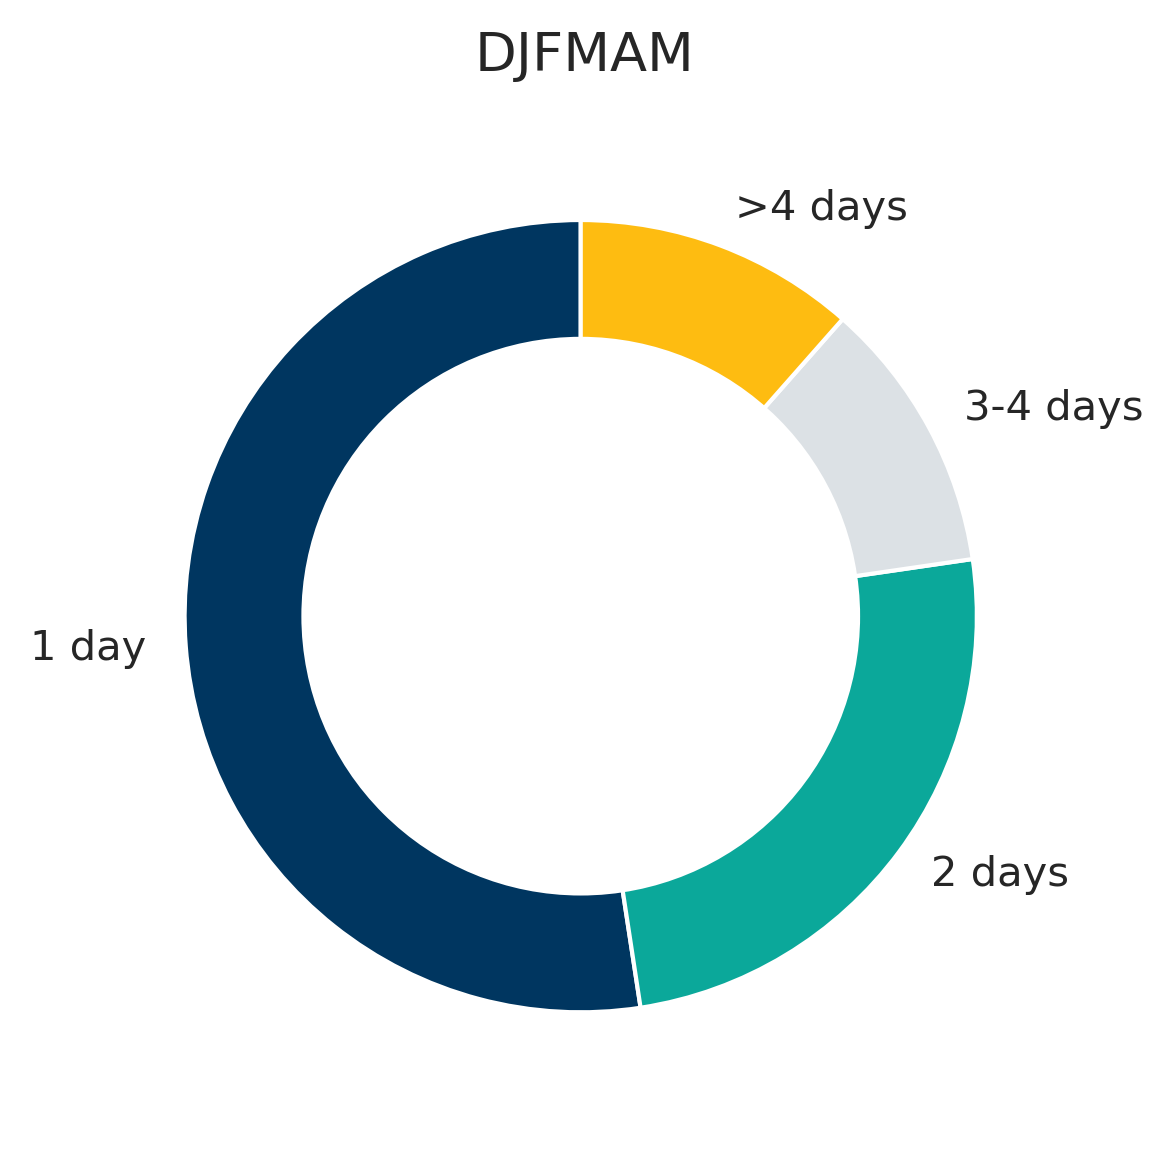

In [26]:
fname = path_to_figs + 'donut_plot_duration_freq'
fmt = 'png'

# Pie chart
plt_labels = ['DJFMAM']
labels = ['1 day', '2 days', '3-4 days', '>4 days']
#colors
colors = ['#003660','#0BA89A','#DCE1E5', '#FEBC11']
 
fig = plt.figure()
fig.set_size_inches((4.,4.))
fig.dpi = 300
nrows = 1
ncols = 1
nplots = nrows*ncols
for i in np.arange(nplots):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.pie(freqs[i], colors = colors, labels=labels, autopct=None, startangle=90)
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    plt.title(plt_labels[i], fontsize=13)

plt.tight_layout()
# plt.show()

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=300)

plotFile = fname + '.png'
print(plotFile)

In [27]:
bins = bins = np.array([[0, 24], [24, 2*24], [2*24, 3*24], [3*24, 4*24], [4*24, 5*24], [5*24, 6*24], [6*24, 7*24]])
size2, freq2 = duration_stats(duration_df.duration, bins)

Text(0.0, 1.0, '(a)')

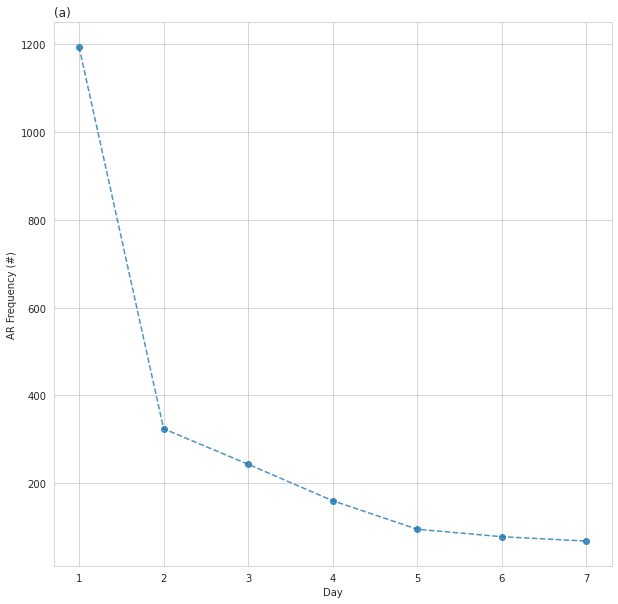

In [28]:
# Create figure
fig = plt.figure(figsize=(10,10))
fname = fig_path + 'ar_duration_category'
fmt = 'png'
nrows = 1
ncols = 1
nplots=nrows*ncols

sns.set_style("whitegrid")


ax = fig.add_subplot(nrows, ncols, 1)

# plot data
xvals = np.arange(1, 8, 1)
yvals = size2
ax.plot(xvals, yvals,'o--', color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('Day')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('AR Frequency (#)')
# ax.set_yticks(np.arange(0, 21, 3))
ax.set_title('(a)', loc='left')

### Westerly Distubance Comparison

In [29]:
def resample_track_id(df):
    '''
    Returns an array that has a single AR track ID for each 24 hr
    
    '''
    df_tmp = wd_df['event_id']

    ## resample to 1D taking maximum of new column
    level_values = df_tmp.index.get_level_values
    df_tmp = df_tmp.groupby([level_values(i) for i in [0,1]]+[pd.Grouper(freq='1D', level=0)]).max()


    # date array with all days
    dates_allDays = pd.date_range(start='1979-01-01', end='2015-01-31', freq='1D')
    arr_allDays = np.zeros(len(dates_allDays), dtype=np.float)
    arr_allDays[:] = np.nan

    # Loop over AR days ID and match to list of ALL days 
    for i, date in enumerate(df_tmp.index.get_level_values(2)):
        idx = np.where(dates_allDays == date)
        arr_allDays[idx] = df_tmp.values[i]

    return arr_allDays

In [30]:
filename = path_to_data + 'CEDA/bitmap_era-interim-derived-wd-tracks.csv'
df2 = pd.read_csv(filename, header=29, skiprows=[29], parse_dates=['time'], skipfooter=1, engine='python')
df2 = df2.set_index(pd.to_datetime(df2.time))
df2

,event_id,lon,lat,intensity,size,eccentricity,signal,time,vorticity,timestep_id
time,,,,,,,,,,
1979-01-01 00:00:00,45,40.290852,37.471957,14426.318010,3.195122,0.235435,315.125969,1979-01-01 00:00:00,0.000067,0
1979-01-01 00:00:00,48,61.892062,31.935886,19019.216980,3.271355,0.064982,372.196027,1979-01-01 00:00:00,0.000079,0
1979-01-01 06:00:00,45,43.736661,36.014512,16910.263330,3.201646,0.154904,358.922838,1979-01-01 06:00:00,0.000074,1
1979-01-01 06:00:00,48,64.076665,31.806202,17289.631140,3.286019,0.039174,336.206203,1979-01-01 06:00:00,0.000073,1
1979-01-01 12:00:00,45,47.757141,34.824067,16786.617450,3.226879,0.158068,346.145316,1979-01-01 12:00:00,0.000071,2
...,...,...,...,...,...,...,...,...,...,...
2015-01-31 12:00:00,379773,96.866678,44.752343,12823.753090,3.351098,0.067031,229.623205,2015-01-31 12:00:00,0.000055,52718
2015-01-31 12:00:00,379850,99.100541,29.104065,9946.433741,3.278261,0.240604,192.133702,2015-01-31 12:00:00,0.000049,52718
2015-01-31 18:00:00,379761,61.183830,36.640286,14908.012550,3.204625,0.165131,316.832230,2015-01-31 18:00:00,0.000077,52719


In [31]:
# total number of WDs 
nevents2 = df2['event_id'].nunique()
print('Total number of WD events: ', nevents2)
wd_df = select_months(df2, 12, 5)
print('Total number of WD events in DJFMAM: ', wd_df['event_id'].nunique())

Total number of WD events:  3090
Total number of WD events in DJFMAM:  2631


In [32]:
df_tmp = wd_df['event_id']
## resample to 1D taking maximum of event_id
df_tmp = df_tmp.groupby([pd.Grouper(freq='1D', level=0)]).max()
wd_daily = df_tmp


In [33]:
# select only rows with WWD
idx = (wd_daily.values > 0)
wd_events = wd_daily.loc[idx]

# select only rows with AR
idx = (djfmam_df.ar > 0)
djfmam_df = djfmam_df.loc[idx]

In [34]:
x = wd_events.index
y = djfmam_df.index.normalize()

WD_count = wd_events.loc[x.isin(y)]
perc1 = (len(WD_count)/len(wd_events))*100
print(round(perc1, 2), '% of WWDs are associated with an AR')
      
AR_count = djfmam_df.loc[y.isin(x)]
perc2 = (len(AR_count)/len(djfmam_df))*100
print(round(perc2, 2), '% of ARs are associated with a WWD')

42.14 % of WWDs are associated with an AR
73.9 % of ARs are associated with a WWD


In [35]:
## Print all info at once!

# how many ARs in HMA between start date and end date?
print('Number of ARs between 1979 and 2019: ', df.ar.sum())
# how many ARs on average per year?
print('Average number of ARs per year: ', round(df.ar.sum()/39., 2))

# How many AR days per season?
print('Number of AR days: ')
print('DJF: ', len(djf_df))
print('MAM: ', len(mam_df))
print('DJFMAM: ', len(djfmam_df))
print('Average number of ARs per DJFMAM', round(len(djfmam_df)/40., 2))
print('Number of unique ARs in DJFMAM', trackID_ct)

# print stats for WWD
print('Total number of WD events: ', nevents2)
print('Total number of WD events in DJFMAM: ', wd_df['event_id'].nunique())

print(round(perc1, 2), '% of WWDs are associated with an AR')
print(round(perc2, 2), '% of ARs are associated with a WWD')

Number of ARs between 1979 and 2019:  6634.0
Average number of ARs per year:  170.1
Number of AR days: 
DJF:  1399
MAM:  1758
DJFMAM:  3157
Average number of ARs per DJFMAM 78.92
Number of unique ARs in DJFMAM 2278
Total number of WD events:  3090
Total number of WD events in DJFMAM:  2631
42.14 % of WWDs are associated with an AR
73.9 % of ARs are associated with a WWD
